In [1]:
import pandas as pd
data = pd.read_csv(filepath_or_buffer='./data/00-TCGA-CDR.csv', encoding='utf-8')

'''Extract vital_status
vital_types = data['vital_status'].astype('category').cat.categories.tolist()
vital_types

> ['Alive', 'Dead', '[Discrepancy]']
'''

# Extract tumor type in type
tumor_types = data['type'].astype('category').cat.categories.tolist()
# tumor_types[0]
types_len = len(tumor_types)
# 33

# Extract matched tumor type datasets
data_tumor = data.loc[data['type'] == tumor_types[1]]

# Update! OS = Overall survival
# Update! OS.time = Overall survival time
# Replace value 'vital_status' Alive -> 1, the others -> 0 (right censored)
# data_tumor.replace({'vital_status':'Alive'}, {'vital_status':1}, inplace=True)
# data_tumor.replace({'vital_status':'Dead'}, {'vital_status':0}, inplace=True)
# data_tumor.replace({'vital_status':'[Discrepancy]'}, {'vital_status':0}, inplace=True)
data_tumor.fillna(0, inplace=True)
data_tumor.drop(columns=['Unnamed: 0'], inplace=True)

# Replace value 'vital_status' Alive -> 1, the others -> 0 (right censored)
# data_tumor = data_tumor.replace({'vital_status':'Alive'}, {'vital_status':1})
# data_tumor = data_tumor.replace({'vital_status':'Dead'}, {'vital_status':0})
# data_tumor = data_tumor.replace({'vital_status':'[Discrepancy]'}, {'vital_status':0})

# Extract the numerical columns header
numerical_columns = data_tumor.select_dtypes(include=[int, float]).columns.tolist()
#print(numerical_columns)

# Extract the numerical columns from the dataframe
df = data_tumor.loc[:, numerical_columns]

C:\Users\user\AppData\Local\Temp\ipykernel_14744\3681437129.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_tumor.fillna(0, inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_14744\3681437129.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_tumor.drop(columns=['Unnamed: 0'], inplace=True)


In [2]:
# 1차 assumption check
from lifelines import CoxPHFitter
import warnings

#Cox PH 모델은 변수의 영향이 시간과 무관하다고 가정합니다.
#따라서 Cox PH 모델로 생존을 예측하려면
# 예측에 사용할 변수가 정말 시간과 무관한지 검증하는 것이 좋습니다.

#Cox PH 모델은 변수가 생존에 영향을 주지만 그 영향은 시간과 관계없다고 가정합니다.
# 예를 들어 흡연자는 비흡연자보다 사망 위험이 높지만
# 담배를 갓 피우기 시작한 대학생이나 30년 넘게 피운 중년이나 동일하게 위험하다고 가정합니다.

# cox = CoxPHFitter(penalizer=0.1)
# cox.fit(df, duration_col='OS.time', event_col='OS', show_progress=True)
# try:
#     cox.check_assumptions(df, p_value_threshold=0.05, show_plots=False)
# except ConvergenceWarning as w:
#     warning_message = str(w)
#     print(warning_message)

cox = CoxPHFitter(penalizer=0.1)
cox.fit(df, duration_col='OS.time', event_col='OS', show_progress=True)
cox.check_assumptions(df, p_value_threshold=0.05, show_plots=False)

#위 차트는 각 변수의 Schoenfeld residual을 그린 것입니다.
# Schoenfeld residual은 해당 시각에 이탈한 대상의 변숫값과 생존한 대상들로 계산한 기대값의 차이를 계산한 것입니다.
# 변숫값이 시간에 무관하고 모델이 β를 잘 추정했다면
# Schoenfeld residual은 모든 시간에서 0에 되도록 가까워야 합니다.
# 하지만 위 차트의 일부 점들이 현저하게 벗어난 것을 볼 수 있습니다.

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\lifelines\utils\__init__.py:1102: ConvergenceWarning: Column(s) ['margin_status', 'residual_tumor'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\lifelines\utils\__init__.py:800: RuntimeWarning: invalid value encountered in divide
  return (X - mean) / std
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\lifelines\utils\__init__.py:1122: ConvergenceWarning: Column DSS have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['OS'].astype(bool)
>>> print(df.loc[events, 'DSS'].var())
>

ConvergenceError: delta contains nan value(s). Convergence halted. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model

In [3]:
# Drop the column which have very low variance that may harm convergence
df_selected = df.drop(columns=['margin_status', 'residual_tumor'], inplace=False)

Iteration 1: norm_delta = 9.36e-01, step_size = 0.9500, log_lik = -968.20834, newton_decrement = 1.44e+02, seconds_since_start = 0.0
Iteration 2: norm_delta = 8.43e-01, step_size = 0.9500, log_lik = -821.38217, newton_decrement = 5.16e+01, seconds_since_start = 0.0
Iteration 3: norm_delta = 4.38e-01, step_size = 0.9500, log_lik = -762.37218, newton_decrement = 1.04e+01, seconds_since_start = 0.0
Iteration 4: norm_delta = 7.66e-02, step_size = 1.0000, log_lik = -751.02544, newton_decrement = 2.45e-01, seconds_since_start = 0.0
Iteration 5: norm_delta = 1.43e-03, step_size = 1.0000, log_lik = -750.77782, newton_decrement = 8.90e-05, seconds_since_start = 0.0
Iteration 6: norm_delta = 5.61e-07, step_size = 1.0000, log_lik = -750.77773, newton_decrement = 1.56e-11, seconds_since_start = 0.0
Convergence success after 6 iterations.

   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 412 total observations, 231 right-censored observations>
         test_name = proportional_hazard_test

---
                                          test_statistic    p  -log2(p)
DFI                                 km              1.14 0.29      1.80
                                    rank            1.45 0.23      2.13
DFI.time                            km              0.99 0.32      1.65
                                    rank            0.68 0.41      1.29
DSS                                 km              0.17 0.68      0.56
                                    rank            0.03 0.86      0.21
DSS.time                            km              0.12 0.73      0.45
                                    rank            0.05 0.82      0.28
PFI                                 km              0.02 0.89      0.17
                                    rank            0.05 0.83      0.27
PFI.time                            km              2.40 0.12      3.05
                                    rank            2.29 0.13      2.94
age_at_initial_pathologic_diagnosis km              0.19 0.66      0.60
                                    rank            0.25 0.62      0.69
birth_days_to                       km              0.07 0.79      0.33
                                    rank            0.09 0.76      0.39
death_days_to                       km              5.87 0.02      6.02
                                    rank            4.80 0.03      5.13
initial_pathologic_dx_year          km              0.22 0.64      0.65
                                    rank            0.17 0.68      0.56
last_contact_days_to                km              1.32 0.25      2.00
                                    rank            0.92 0.34      1.56
new_tumor_event_dx_days_to          km              1.35 0.24      2.03
                                    rank            0.70 0.40      1.31



1. Variable 'death_days_to' failed the non-proportional test: p-value is 0.0154.

   Advice 1: the functional form of the variable 'death_days_to' might be incorrect. That is, there
may be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'death_days_to' using pd.cut, and then specify it in
`strata=['death_days_to', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstr

[[<Axes: xlabel='rank-transformed time\n(p=0.6182)'>,
  <Axes: xlabel='km-transformed time\n(p=0.6612)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.6761)'>,
  <Axes: xlabel='km-transformed time\n(p=0.6375)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.7631)'>,
  <Axes: xlabel='km-transformed time\n(p=0.7936)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.3383)'>,
  <Axes: xlabel='km-transformed time\n(p=0.2504)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0285)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0154)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.4030)'>,
  <Axes: xlabel='km-transformed time\n(p=0.2446)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.8633)'>,
  <Axes: xlabel='km-transformed time\n(p=0.6781)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.8229)'>,
  <Axes: xlabel='km-transformed time\n(p=0.7345)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.2278)'>,
  <Axes: xlabel='km-transformed time\n(p=0.2865)'>],
 [<Axes: xlabel='rank-transformed tim

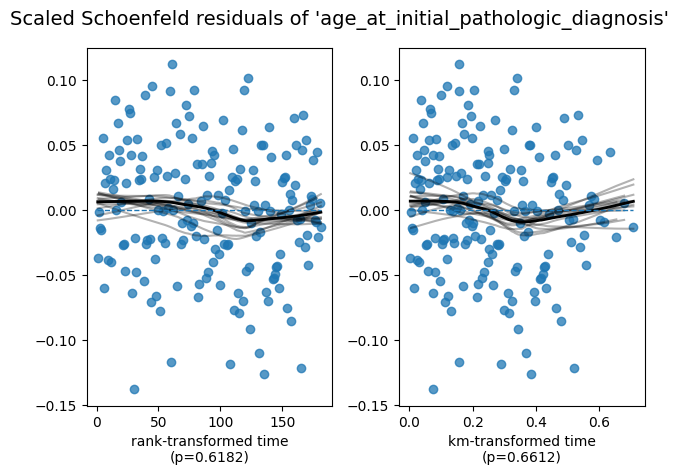

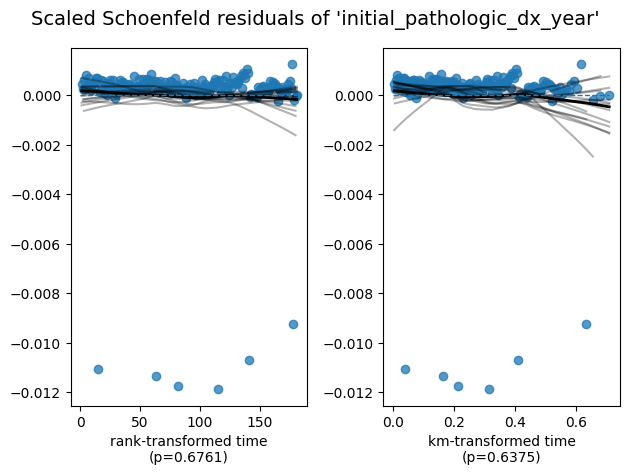

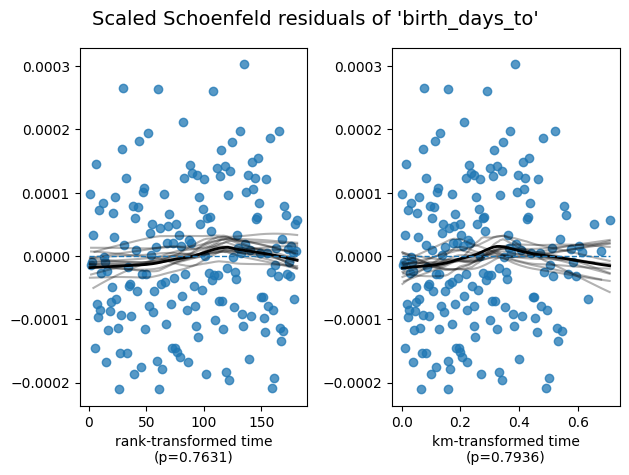

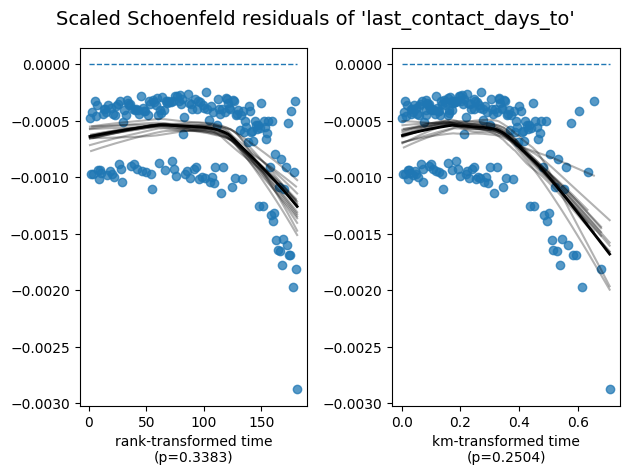

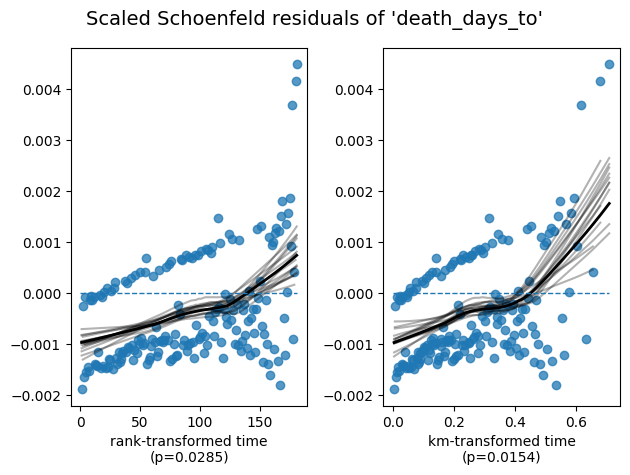

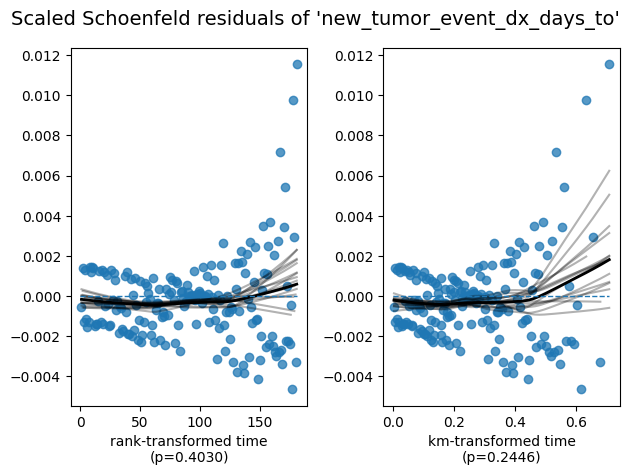

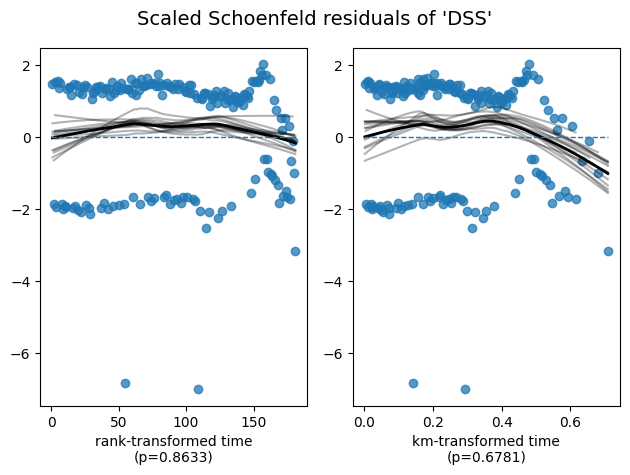

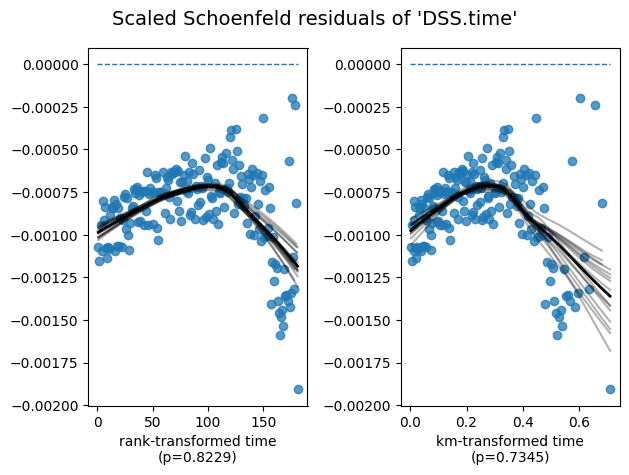

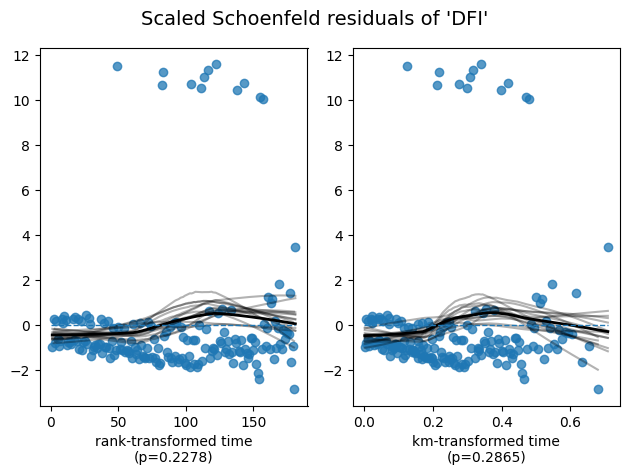

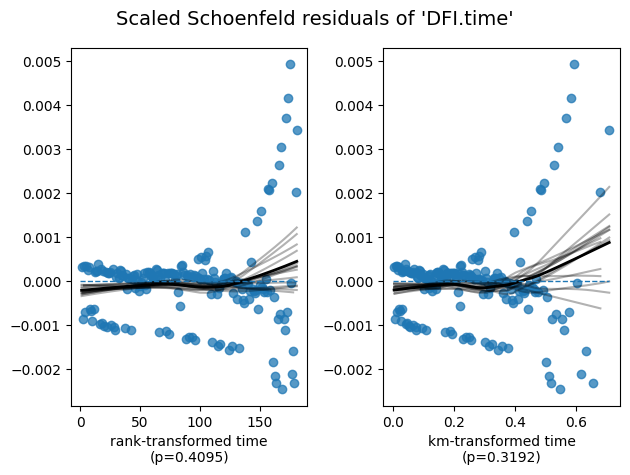

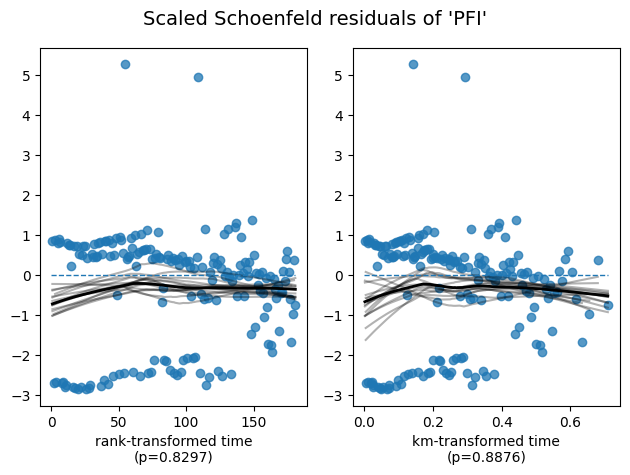

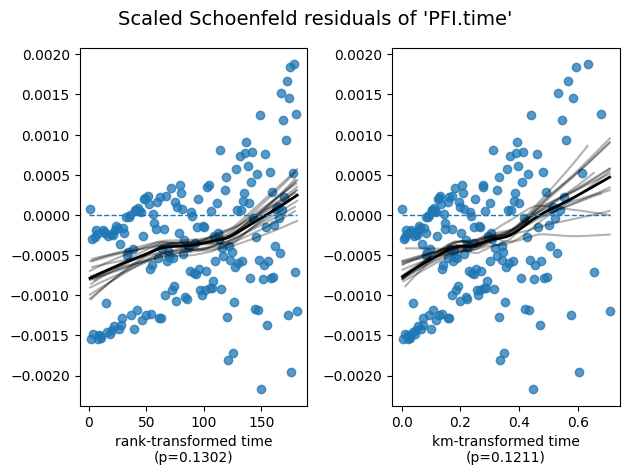

In [4]:
from lifelines import CoxPHFitter

#Cox PH 모델은 변수의 영향이 시간과 무관하다고 가정합니다.
#따라서 Cox PH 모델로 생존을 예측하려면
# 예측에 사용할 변수가 정말 시간과 무관한지 검증하는 것이 좋습니다.

#Cox PH 모델은 변수가 생존에 영향을 주지만 그 영향은 시간과 관계없다고 가정합니다.
# 예를 들어 흡연자는 비흡연자보다 사망 위험이 높지만
# 담배를 갓 피우기 시작한 대학생이나 30년 넘게 피운 중년이나 동일하게 위험하다고 가정합니다.

cox = CoxPHFitter(penalizer=0.1)
cox.fit(df_selected, duration_col='OS.time', event_col='OS', show_progress=True)
cox.check_assumptions(df_selected, p_value_threshold=0.05, show_plots=True)

# cox = CoxPHFitter(penalizer=0.1)
# cox.fit(df, duration_col='death_days_to', event_col='vital_status', show_progress=True)
# cox.check_assumptions(df, p_value_threshold=0.05, show_plots=True)

#위 차트는 각 변수의 Schoenfeld residual을 그린 것입니다.
# Schoenfeld residual은 해당 시각에 이탈한 대상의 변숫값과 생존한 대상들로 계산한 기대값의 차이를 계산한 것입니다.
# 변숫값이 시간에 무관하고 모델이 β를 잘 추정했다면
# Schoenfeld residual은 모든 시간에서 0에 되도록 가까워야 합니다.
# 하지만 위 차트의 일부 점들이 현저하게 벗어난 것을 볼 수 있습니다.

# https://velog.io/@hajeongjj/Survival-Analysis
# 귀무: 예측에 사용할 변수가 시간과 무관하다 (p>0.05)
# 기각: 변수가 시간에 영향이 있다. (p<0.05)


In [18]:
from lifelines.utils import concordance_index

# Compute the concordance index
# event_times: a length-n iterable of observed time
# event_observed: a length-n iterable censoring flags, 1 if observed, 0 if not or censored
# predicted_scores: a length-n iterable, these could be survival times or hazards

c_index = concordance_index(
    event_times=df['OS.time'],
    event_observed=df['OS'],
    predicted_scores=-df['age_at_initial_pathologic_diagnosis'])

c_index

0.5990018700853931

In [17]:
from lifelines.utils import concordance_index
from lifelines import CoxPHFitter

#C-index
# Survival Analysis에서 가장 많이 사용하는 정확도 지표입니다. 대상의 정확한 생존 시간을 평가하지 않고,
# 대신 여러 대상의 생존 시간(또는 위험)을 상대적으로 비교합니다. 즉, 사망 순서를 잘 예측하는지 판단합니다.

cph = CoxPHFitter(penalizer=0.1).fit(df_selected, duration_col='OS.time', event_col='OS')
c_index = concordance_index(
    event_times=df_selected['OS.time'],
    predicted_scores=-cph.predict_partial_hazard(df_selected),
    event_observed=df_selected['OS'])
print(c_index)
cph.print_summary()

#adding a penalizer to the model,
#ex: CoxPHFitter(penalizer=0.1).fit(…) until the model converges.
#In the print_summary(), the coefficients that have high collinearity will have large (absolute) magnitude in the coefs column.

0.9376563098483653


<lifelines.CoxPHFitter: fitted with 412 total observations, 231 right-censored observations>
             duration col = 'OS.time'
                event col = 'OS'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 412
number of events observed = 181
   partial log-likelihood = -750.78
         time fit was run = 2023-12-07 02:37:11 UTC

---
                                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                   
age_at_initial_pathologic_diagnosis   0.01       1.01       0.01            -0.01             0.03                 0.99                 1.03
initial_pathologic_dx_year            0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
birth_days_to                        -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
last_contact_days_to                 -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
death_days_to                        -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
new_tumor_event_dx_days_to           -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
DSS                                   1.07       2.92       0.21             0.65             1.49                 1.92                 4.43
DSS.time                             -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
DFI                                  -0.13       0.88       0.27            -0.65             0.40                 0.52                 1.49
DFI.time                             -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
PFI                                  -0.11       0.90       0.21            -0.53             0.31                 0.59                 1.37
PFI.time                             -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00

                                      cmp to     z      p   -log2(p)
covariate                                                           
age_at_initial_pathologic_diagnosis     0.00  1.04   0.30       1.75
initial_pathologic_dx_year              0.00  0.19   0.85       0.23
birth_days_to                           0.00 -1.12   0.26       1.93
last_contact_days_to                    0.00 -7.09 <0.005      39.39
death_days_to                           0.00 -1.04   0.30       1.74
new_tumor_event_dx_days_to              0.00 -3.36 <0.005      10.35
DSS                                     0.00  5.04 <0.005      21.04
DSS.time                                0.00 -7.54 <0.005      44.23
DFI                                     0.00 -0.47   0.64       0.65
DFI.time                                0.00 -2.06   0.04       4.66
PFI                                     0.00 -0.49   0.62       0.69
PFI.time                                0.00 -4.55 <0.005      17.49
---
Concordance = 0.94
Partial AIC = 1525.56
log-likelihood ratio test = 434.86 on 12 df
-log2(p) of ll-ratio test = 281.74

In [ ]:
# NEW

In [2]:
import pandas as pd
data_surv = pd.read_csv(filepath_or_buffer='./data/00-TCGA-CDR.csv', encoding='utf-8')
data_surv.drop(columns=['Unnamed: 0'], inplace=True)

# Extract tumor type in type
tumor_types = data_surv['type'].astype('category').cat.categories.tolist()
# tumor_types[0]

# Extract matched tumor type datasets
data_tumor = data_surv.loc[data_surv['type'] == tumor_types[1]]
data_tumor.fillna(0, inplace=True)

# Extract the numerical columns header
numerical_columns = data_tumor.select_dtypes(include=[int, float]).columns.tolist()
#print(numerical_columns)

# Extract the numerical columns from the dataframe
df = data_tumor.loc[:, numerical_columns]

C:\Users\user\AppData\Local\Temp\ipykernel_19920\629006982.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_tumor.fillna(0, inplace=True)


In [18]:
f01_cnv = pd.read_csv(filepath_or_buffer='./data/01-CNV burden scores - seg_based_scores.tsv', sep='\\t', encoding='utf-8')

# Remove last three characters in Sample column
f01_cnv['Sample'] = f01_cnv['Sample'].str[:-3]

# Extract feature rows by survival bcr_patient_barcode
f01_cnv_bytype = f01_cnv[f01_cnv['Sample'].isin(data_tumor['bcr_patient_barcode'])]

# Common elements between survival - feature
common_elements = list(set(data_tumor['bcr_patient_barcode']).intersection(f01_cnv_bytype['Sample']))

# Extract common elements from both dataframes
data_tumor_common = data_tumor[data_tumor['bcr_patient_barcode'].isin(common_elements)]

# Extract numerical features from feature dataframe
numeric_flist = f01_cnv_bytype.select_dtypes(include=[int, float]).columns.tolist()
f01_cnv_bytype_numeric = f01_cnv_bytype.loc[:, numeric_flist]


C:\Users\user\AppData\Local\Temp\ipykernel_19920\2083884799.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  f01_cnv = pd.read_csv(filepath_or_buffer='./data/01-CNV burden scores - seg_based_scores.tsv', sep='\\t', encoding='utf-8')


In [23]:
# Return Concordance_index
from lifelines.utils import concordance_index

# Compute the concordance index
# event_times: a length-n iterable of observed time
# event_observed: a length-n iterable censoring flags, 1 if observed, 0 if not or censored
# predicted_scores: a length-n iterable, these could be survival times or hazards

# concordance_index must have same shape
c_index = concordance_index(
    event_times=data_tumor_common['OS.time'],
    event_observed=data_tumor_common['OS'],
    predicted_scores=-f01_cnv_bytype['frac_altered'])

c_index

0.500114458382932

In [31]:
numeric_dlist = data_tumor_common.select_dtypes(include=[int, float]).columns.tolist()
data_tumor_common_numeric = data_tumor_common.loc[:, numeric_dlist]

In [32]:
# predict_partial_hazard model
from lifelines.utils import concordance_index
from lifelines import CoxPHFitter

#C-index
# Survival Analysis에서 가장 많이 사용하는 정확도 지표입니다. 대상의 정확한 생존 시간을 평가하지 않고,
# 대신 여러 대상의 생존 시간(또는 위험)을 상대적으로 비교합니다. 즉, 사망 순서를 잘 예측하는지 판단합니다.

cph = CoxPHFitter().fit(data_tumor_common_numeric, duration_col='OS.time', event_col='OS')
c_index = concordance_index(
    event_times=data_tumor_common['OS.time'],
    predicted_scores=-cph.predict_partial_hazard(f01_cnv_bytype_numeric),
    event_observed=data_tumor_common['OS'])
cph.print_summary()

#adding a penalizer to the model,
#ex: CoxPHFitter(penalizer=0.1).fit(…) until the model converges.
#In the print_summary(), the coefficients that have high collinearity will have large (absolute) magnitude in the coefs column.

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\lifelines\utils\__init__.py:1102: ConvergenceWarning: Column(s) ['margin_status', 'residual_tumor'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\lifelines\utils\__init__.py:800: RuntimeWarning: invalid value encountered in divide
  return (X - mean) / std
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\lifelines\utils\__init__.py:1122: ConvergenceWarning: Column DSS have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['OS'].astype(bool)
>>> print(df.loc[events, 'DSS'].var())
>

ConvergenceError: delta contains nan value(s). Convergence halted. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model